How to do Unsupervised Clustering with Keras | DLology
Read my blog post for details.

https://github.com/Tony607/Keras_Deep_Clustering



In [2]:
import numpy as np
np.random.seed(10)
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from time import time

from keras.datasets import mnist

import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from keras.callbacks import EarlyStopping

/apps/cent7/anaconda/5.1.0-py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/apps/cent7/anaconda/5.1.0-py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/apps/cent7/anaconda/5.1.0-py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [5]:
# OHLC plot function

import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from matplotlib.finance import candlestick2_ohlc

#plt.plot(t, df['Close'], marker='o', markersize=3, color = 'black', linewidth=0)

def plot_ohlc_data(df):
    fig, ax = plt.subplots()

    candlestick2_ohlc(ax, 
                  opens  = df['Open'], 
                  highs  = df['High'], 
                  lows   = df['Low'], 
                  closes = df['Close'],
                  width  = 0.6, 
                  colorup= 'green',
                  colordown = 'red')

    #xdate = [datetime.datetime.fromtimestamp(i) for i in df.index.values]

    #ax.xaxis.set_major_locator(ticker.MaxNLocator(6))

def mydate(x,pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))

    fig.autofmt_xdate()
    fig.tight_layout()

    plt.show()
  
#plot_ohlc_data(df)


In [6]:
data_dir = '../input/'
data_file_name = 'BTCUSDT_5m_from_2018-3-1_to_2018-7-19.pkl'
dataset = data_dir + data_file_name

df = pd.read_pickle(dataset)
df = df.sort_index()
df['OHLC'] = df.mean(axis=1)
df["H/O"] = df["High"]/df["Open"]
df["L/O"] = df["Low"]/df["Open"]
df["C/O"] = df["Close"]/df["Open"]
   
#df.head()
#df.plot()

X = df[['H/O', 'L/O', 'C/O']]

In [7]:
print(X.shape)
X.head()

(60500, 3)


,H/O,L/O,C/O
2018-03-01 00:45:00,1.000118,0.996643,0.997299
2018-03-01 00:50:00,1.004334,0.999255,1.003216
2018-03-01 00:55:00,1.003396,0.998333,1.002337
2018-03-01 01:00:00,1.000288,0.997191,0.998520
2018-03-01 01:05:00,1.000412,0.997238,0.998896


In [8]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
# Stacked autoencoder
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)
    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [ ]:
dims = [64, 128, 256]
autoencoder, encoder = autoencoder(dims)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

# Finding optimal number of clusters
This tutorial explains how to find optimal number of clusters in a given dataset by using various techniques.
Different techniques discussed here are
Dendogram
Elbow method
Silhoutte score Analysis
We will first load the data into dataframe and scale the features and create clusters. And then various metrics are calculated to validate the number of cluster creations and what will be the optimal number of clusters.

In [9]:
import  pandas as  pd
import  numpy as  np
import  matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
%matplotlib inline


X = np.array(X)
X = X#.reshape(-1, 1) # for 1D
print(X.shape)

(60500, 3)


/apps/cent7/anaconda/5.1.0-py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Using Dendogram
Dendogram shows the distance between any two observations in a dataset. The vertical axis determines the distance. The longer the axis, the larger the distance.
The clustermap feature in seaborn provides the dendogram. It also displays the distance between observations as well as the features. But we are mostly interested in observations.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

print(X_scaled.shape)

(60500, 3)


In [ ]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

In [ ]:
sn.clustermap(X_scaled, cmap=cmap, linewidths=.5)

Note:
From the diagram it can observed that the number of clusters or groups of observations present are between 3 to 6. Based on business context the number of clusters can be created.

# Elbow Analysis
This is taken from wikipedia)
The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.
Explained Variance: This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.
if one plots the percentage of variance explained by the clusters against the number of clusters the first clusters will add much information (explain a lot of variance), but at some point the marginal gain in explained variance will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion"
Given a set of observations (x1, x2, …, xn), where each observation is a d-dimensional real vector, k-means clustering aims to partition the n observations into k (≤ n) sets S = {S1, S2, …, Sk} so as to minimize the within-cluster sum of squares (WCSS) (sum of distance functions of each point in the cluster to the K center).
In other words, its objective is to find:


In [ ]:
cluster_range = range( 1, 50 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( X_scaled )
    cluster_errors.append( clusters.inertia_ )

In [ ]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:10]

In [ ]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [14]:
opt_cluster_num = 30
#del clusters
clusters = KMeans(opt_cluster_num)
clusters.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
print(clusters.labels_.shape)
print(df.shape)
print(X_scaled.shape)

(60500,)
(60500, 8)
(60500, 3)


Note:
The elbow diagram shows that the gain in explained variance reduces significantly from 3 to 4 to 5. So, optimal number of clusters could either 4 or 5. The actual number of clusters chosen can be finally based on business context and convenience of dealing with number of segments or clusters.

# Silhouette Analysis
Taken from wikipedia
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.
Silhouette score of an observation is given by:

$s(i)=b(i)−a(i)max{a(i),b(i)}$
 
Which can be also written as:

s(i)=⎧⎩⎨⎪⎪1−a(i)/b(i),0,b(i)/a(i)−1,if a(i)<b(i)if a(i)=b(i)if a(i)>b(i)
 
From the above definition it is clear that silhoutte score always lies between.

−1≤s(i)≤1−1≤s(i)≤1
 
Score closer to 1 means assigned to the cluster correctly and score closer to -1 is assigned to a wrong cluster. A score close to 0 means the point lies between almost at the boundary of both the clusters.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_range = range( 2,15 )
for n_clusters in cluster_range:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict( X_scaled )
    

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

    plt.show()

In [ ]:
n_clusters = len(np.unique(y))
print(n_clusters)
print(x.shape)

In [16]:
dfc = df[['Open', 'High', 'Low', 'Close']]
df['Cluster'] = clusters.labels_
#dfc['Cluster'] = clusters.labels_

In [17]:
import copy
from matplotlib.finance import candlestick2_ohlc
from matplotlib.finance import candlestick_ohlc


def plot_candlesticks(data, frm, to):
    """
    Plot a candlestick chart of the prices,
    appropriately formatted for dates
    """
    # Copy and reset the index of the dataframe
    # to only use a subset of the data for plotting
    df = copy.deepcopy(data)
    df = df[(df.index >= frm) & (df.index <= to)]
    
    fig, ax = plt.subplots(figsize=(16,4))
    fig.subplots_adjust(bottom=0.2)
    
    # Plot the candlestick OHLC chart using black for
    # up days and red for down days
    csticks = candlestick2_ohlc(
        ax, df['Open'], df['High'], df['Low'], df['Close'], width=0.6
    )
    xdate = [dt for dt in df.index]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(10))

    def mydate(x,pos):
        try:
            return xdate[int(x)]
        except IndexError:
            return ''

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()
    

In [18]:
print(dfc.head())
#plot_candlesticks(dfc, frm = '2018-03-02 00:50:00', to = '2018-03-02 05:50:00')

                         Open      High       Low     Close
2018-03-01 00:45:00  10384.86  10386.09  10350.00  10356.81
2018-03-01 00:50:00  10356.81  10401.70  10349.09  10390.12
2018-03-01 00:55:00  10385.73  10421.00  10368.42  10410.00
2018-03-01 01:00:00  10407.00  10410.00  10377.77  10391.60
2018-03-01 01:05:00  10389.89  10394.17  10361.19  10378.42


In [19]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_normalised_candles(data):
    """
    Plot a 3D scatterchart of the open-normalised bars
    highlighting the separate clusters by colour
    """
    fig = plt.figure(figsize=(12, 9))
    ax = Axes3D(fig, elev=21, azim=-136)
    ax.scatter(
        data["H/O"], data["L/O"], data["C/O"],
        c=data['Cluster'].astype(np.float)
    )
    ax.set_xlabel('High/Open')
    ax.set_ylabel('Low/Open')
    ax.set_zlabel('Close/Open')
    plt.show()

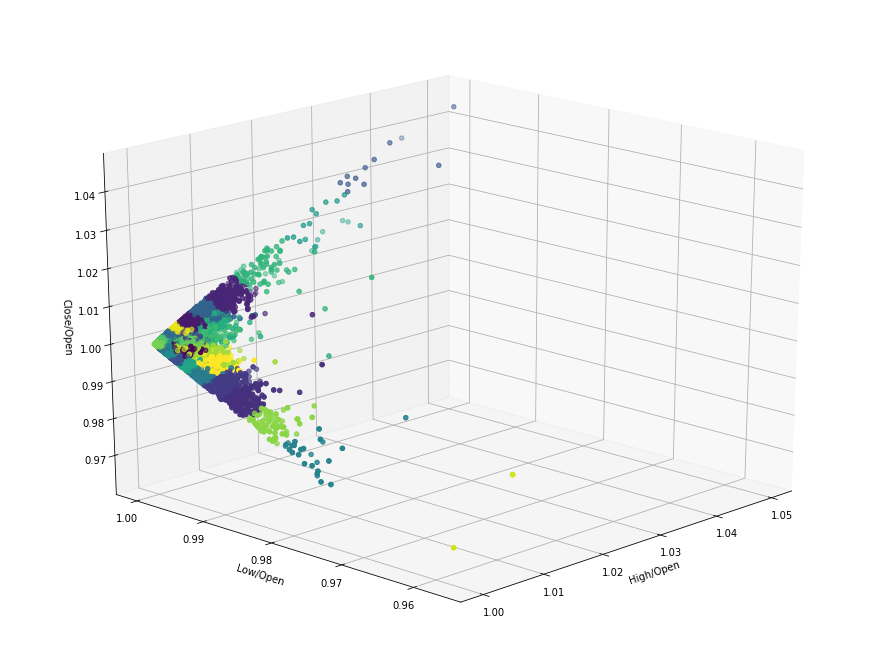

In [20]:
plot_3d_normalised_candles(df)

In [24]:
def plot_cluster_ordered_candles(data):
    """
    Plot a candlestick chart ordered by cluster membership
    with the dotted blue line representing each cluster
    boundary.
    """
    fig, ax = plt.subplots(figsize=(50,50))

    # Sort the data by the cluster values and obtain
    # a separate DataFrame listing the index values at
    # which the cluster boundaries change
    df = copy.deepcopy(data)
    df.sort_values(by="Cluster", inplace=True)
    df.reset_index(inplace=True)
    df["clust_index"] = df.index
    df["clust_change"] = df["Cluster"].diff()
    change_indices = df[df["clust_change"] != 0]

    # Plot the OHLC chart with cluster-ordered "candles"
    csticks = candlestick_ohlc(
        ax, df[
            ["clust_index", 'Open', 'High', 'Low', 'Close']
        ].values, width=0.6,
        colorup='#000000', colordown='#ff0000'
    )
    ax.set_axis_bgcolor((1,1,0.9))

    # Add each of the cluster boundaries as a blue dotted line
    for row in change_indices.iterrows():
        plt.axvline(
            row[1]["clust_index"],
            linestyle="dashed", c="blue"
        )
    plt.xlim(0, len(df))
    plt.setp(
        plt.gca().get_xticklabels(),
        rotation=45, horizontalalignment='right'
    )
    plt.show()

/apps/cent7/anaconda/5.1.0-py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


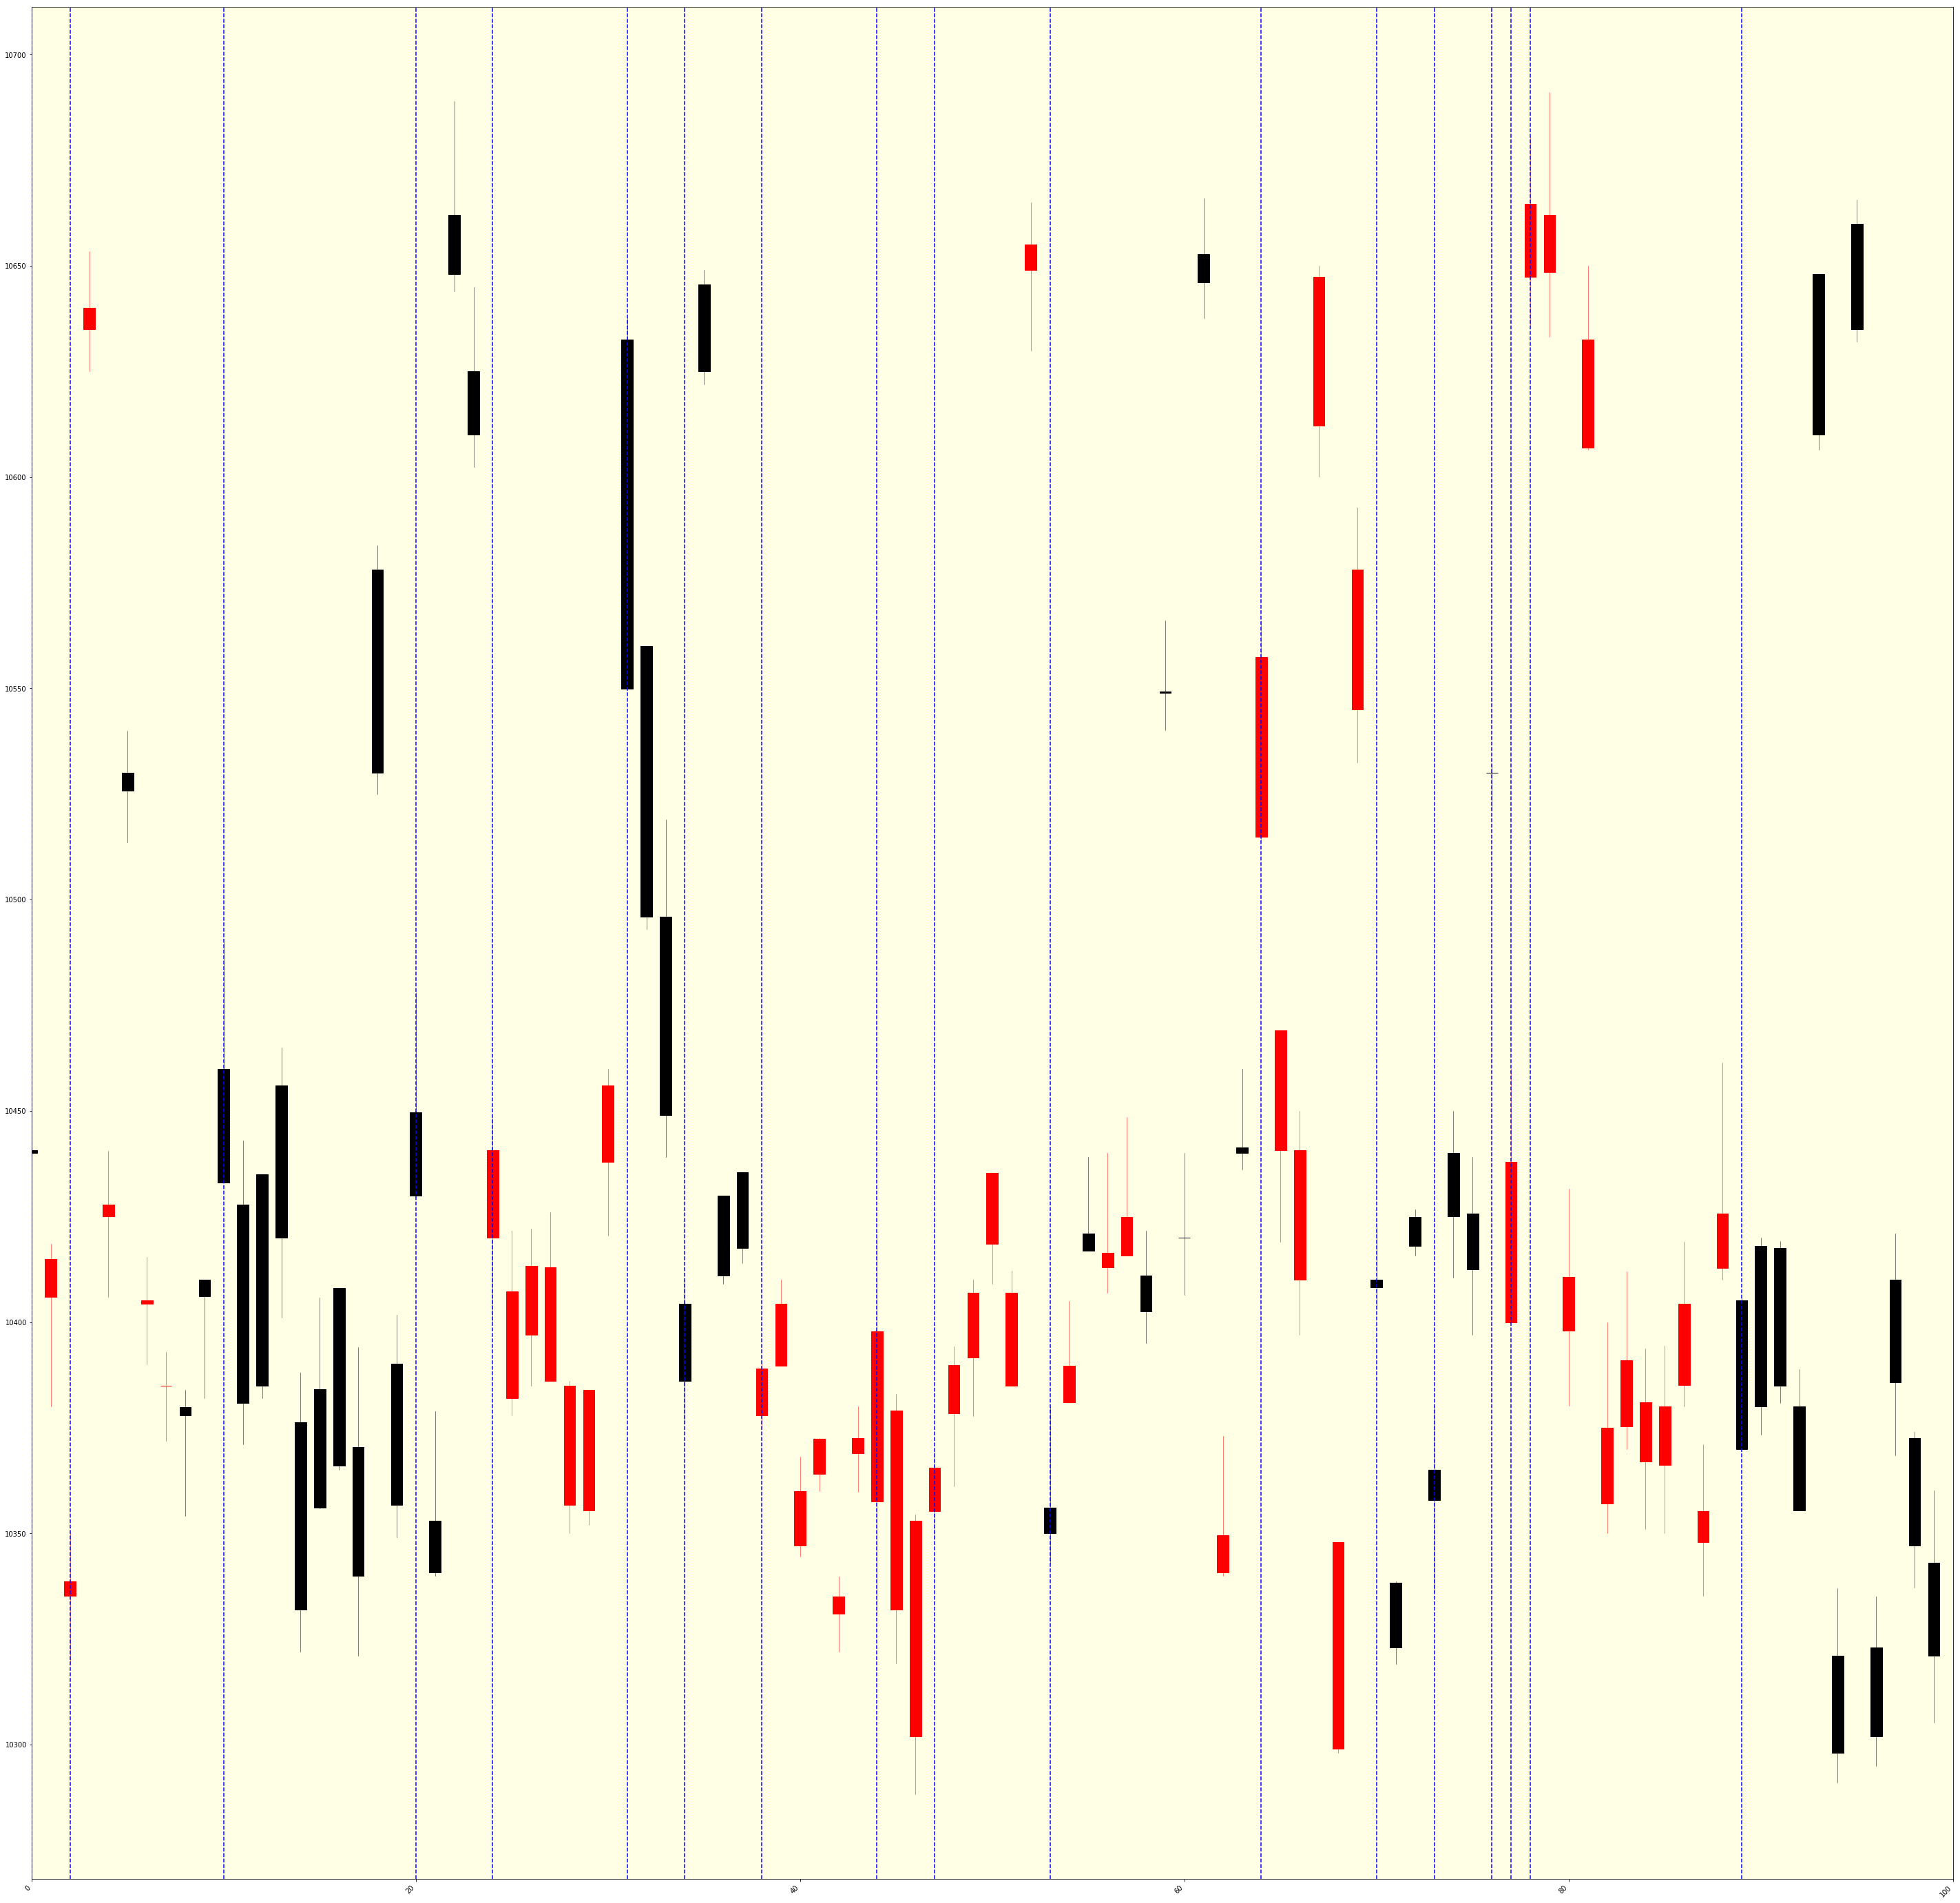

In [25]:
plot_cluster_ordered_candles(df.head(100))

In [29]:
!pip install --user plotly
!pip install --user pandas-datareader

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 112kB 2.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for requests-ftp ... done
  Stored in directory: /home/azehady/.cache/pip/wheels/2a/98/32/37195e45a3392a73d9f65c488cbea30fe5bad76aaef4d6b020
Successfully built requests-ftp
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, download_plotlyjs, plot, iplot

import pandas_datareader as web
from datetime import datetime

df = web.DataReader('aapl', 'morningstar').reset_index()

init_notebook_mode(connected=True)
trace = go.Ohlc(x=df.Date,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [ ]:
def create_follow_cluster_matrix(data):
    """
    Creates a k x k matrix, where k is the number of clusters
    that shows when cluster j follows cluster i.
    """
    data["ClusterTomorrow"] = data["Cluster"].shift(-1)
    data.dropna(inplace=True)
    data["ClusterTomorrow"] = data["ClusterTomorrow"].apply(int)
    sp500["ClusterMatrix"] = list(zip(data["Cluster"], data["ClusterTomorrow"]))
    cmvc = data["ClusterMatrix"].value_counts()
    clust_mat = np.zeros( (k, k) )
    for row in cmvc.iteritems():
        clust_mat[row[0]] = row[1]*100.0/len(data)
    print("Cluster Follow-on Matrix:")
    print(clust_mat)

In [ ]:
create_follow_cluster_matrix(df)

## Base line K-Means clustering accuracy


In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20) #, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)
acc(y, y_pred_kmeans)

In [ ]:
print(y_pred_kmeans)

## Hyper-params

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 5
batch_size = 256
save_dir = '../working'

In [ ]:
# Stacked autoencoder
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)
    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

autoencoder, encoder = autoencoder(dims, init=init)

In [ ]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

In [ ]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

## Pretrain auto-encoder

In [ ]:
pretrain_epochs = 5
early_stopping = EarlyStopping(patience=10, verbose=1)
cb = [early_stopping]
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse') #, callbacks=cb)
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [ ]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights


In [ ]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering model


In [ ]:
# Writing Layers on Keras
# https://keras.io/layers/writing-your-own-keras-layers/#writing-your-own-keras-layers

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means


In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 5 #8000
update_interval = 2 #140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

### Start training

In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score


class metrics():
    nmi = normalized_mutual_info_score
    ari = adjusted_rand_score
    
    def acc(y_true, y_pred):
        """
        Calculate clustering accuracy. Require scikit-learn installed

        # Arguments
            y: true labels, numpy.array with shape `(n_samples,)`
            y_pred: predicted labels, numpy.array with shape `(n_samples,)`

        # Return
            accuracy, in [0,1]
        """
        y_true = y_true.astype(np.int64)
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max()) + 1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        from sklearn.utils.linear_assignment_ import linear_assignment
        ind = linear_assignment(w.max() - w)
        return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [ ]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

### Convolutional auto encoder option 1
Use [`Conv2DTranspose`](https://keras.io/layers/convolutional/#conv2dtranspose) to reconstruct the image.


In [ ]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Convolutional auto encoder option 2
Use [`UpSampling2D`](https://keras.io/layers/convolutional/#upsampling2d) to reconstruct the image.

In [ ]:
def autoencoderConv2D_2(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Pick a convolutional autoencoder
`autoencoderConv2D_1` or `autoencoderConv2D_2`

In [ ]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.summary()

In [ ]:
pretrain_epochs = 10 #100
batch_size = 256

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='mse')

### Load MNIST data for convolutional input

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

### Pretrain covolutional autoencoder

In [ ]:
pretrain_epochs = 10#0
batch_size = 256

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

### Load the pre-trained auto encoder weights

autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

## Build clustering model

### ClusteringLayer

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [ ]:
loss = 0
index = 0
maxiter = 10 #8000
update_interval = 2 #140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

### Start training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = '../working'

In [ ]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

### Initialize cluster centers using k-means


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation


In [ ]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()